# File and libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

filepath=r'dataset/df_msg_feat_eng'

test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

file_tag = "df_msg_feat_eng_input"

# DSLabs functions

In [2]:
%run "scripts/dslabs_functions.py"


# Data functions

In [3]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [4]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    sample=0.05
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    
else:
    data=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

target='is_clicked'
target_metric='f2'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())

# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 461961 entries, 0 to 461960
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   platform            461961 non-null  float64
 1   campaign_type       461961 non-null  float64
 2   channel_cmp         461961 non-null  float64
 3   total_count         461961 non-null  float64
 4   subject_with_emoji  461961 non-null  float64
 5   day_of_year         461961 non-null  float64
 6   is_weekend          461961 non-null  float64
 7   month               461961 non-null  float64
 8   time_of_day         461961 non-null  float64
 9   hour_sin            461961 non-null  float64
 10  min_sin             461961 non-null  float64
 11  min_cos             461961 non-null  float64
 12  day_of_month_sin    461961 non-null  float64
 13  day_of_month_cos    461961 non-null  float64
 14  day_of_week_nr_sin  461961 non-null  float64
 15  day_of_week_nr_cos  461961 non-null  fl

# Balancing Analysis

Minority class= 1.0 : 9586
Majority class= 0.0 : 452375
Original class distribution:
is_clicked
0.0    97.924933
1.0     2.075067
Name: proportion, dtype: float64



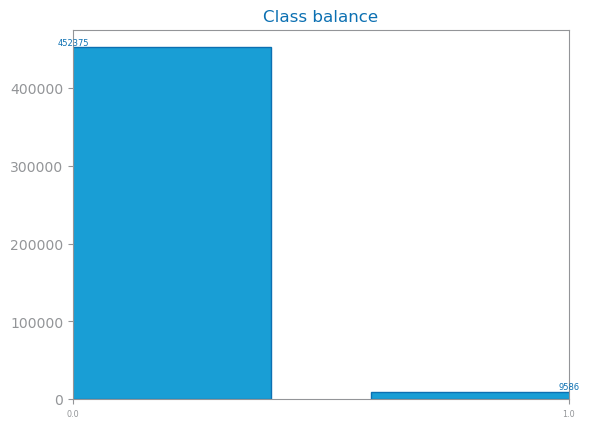

In [5]:
from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart


target_count: Series = data[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

print(f"Original class distribution:\n{data[target].value_counts(normalize=True) * 100}\n")


figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
show()

# Balance 1 - Undersampling


## Bal 1 strategy Application

In [6]:
from pandas import DataFrame, Series
from sklearn.preprocessing import StandardScaler


def apply_strategy_1(df: DataFrame) -> DataFrame:

    df_copy=df.copy()

    df_balanced=apply_balanced_downsampling(df_copy,sort_by='day_of_year')
    
    return df_balanced


train_1=apply_strategy_1(train)
test_1=test.copy()



Original class distribution:
is_clicked
0.0    98.061366
1.0     1.938634
Name: proportion, dtype: float64



Balanced class distribution:
is_clicked
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64



## Bal 1 train/test split 

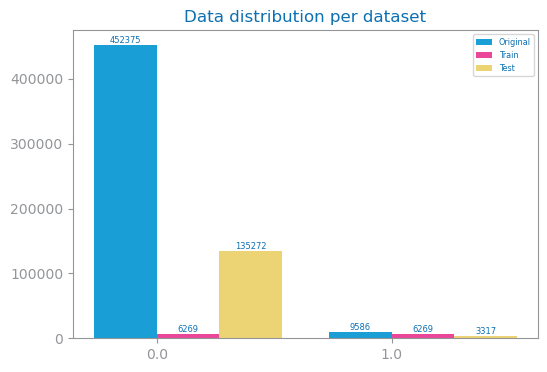

In [7]:
if evaluate==True:
    from pandas import concat
    from matplotlib.pyplot import figure, show
    from dslabs_functions import plot_multibar_chart


    # Distribution check


    # Create a dictionary to store original class counts
    values: dict[str, list[int]] = {
        "Original": [
            len(data[data[target] == 0]),  # Assuming 0 is the negative class
            len(data[data[target] == 1]),  # Assuming 1 is the positive class
        ]
    }

    values["Train"] = [
        len(train_1[train_1[target] == 0]),
        len(train_1[train_1[target] == 1]),
    ]
    values["Test"] = [
        len(test_1[test_1[target] == 0]),
        len(test_1[test_1[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Bal 1 evaluate

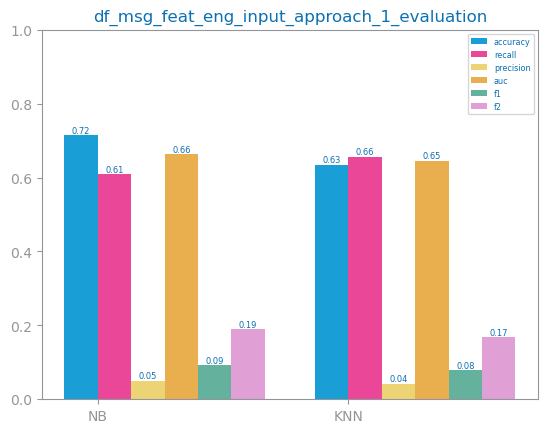

In [8]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values

if evaluate==True:
    figure()
    eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='is_clicked', metric=target_metric)
    plot_multibar_chart(
        ["NB", "KNN"], eval_1, title=f"{file_tag}_approach_1_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_approach_1_evaluation.png")
    show()

# Bal 2 - Hybrid Sampling

Reduce from negative class from 75% and then oversample the positives into making a 60/40 ratio


## Bal 2 strategy aplication

In [9]:


def apply_strategy_2(df):
    # Create a copy of the dataframe
    df_copy = df.copy()

    df_balanced=apply_balanced_hybrid(df_copy,target='is_clicked',minority_ratio=0.5,sort_by='day_of_year')

    return df_balanced


train_2=apply_strategy_2(train)
test_2=test.copy()


Original class distribution:
is_clicked
0.0    98.061366
1.0     1.938634
Name: proportion, dtype: float64

Hybrid class distribution (50.0/50.0):
is_clicked
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64



## Bal 2 distribution check

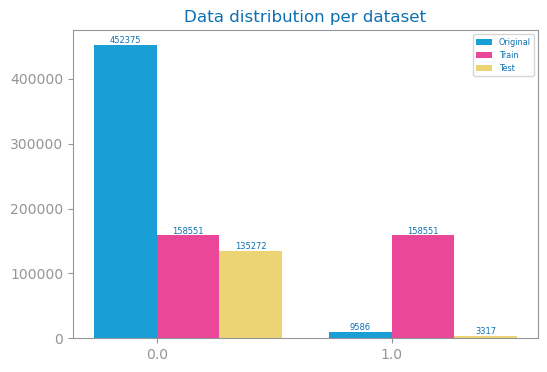

In [10]:
if evaluate==True:

    from matplotlib.pyplot import figure, show
    from dslabs_functions import plot_multibar_chart


    # Distribution check


    # Create a dictionary to store original class counts
    values: dict[str, list[int]] = {
        "Original": [
            len(data[data[target] == 0]),  # Assuming 0 is the negative class
            len(data[data[target] == 1]),  # Assuming 1 is the positive class
        ]
    }

    values["Train"] = [
        len(train_2[train_2[target] == 0]),
        len(train_2[train_2[target] == 1]),
    ]
    values["Test"] = [
        len(test_2[test_2[target] == 0]),
        len(test_2[test_2[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Bal 2 evaluate

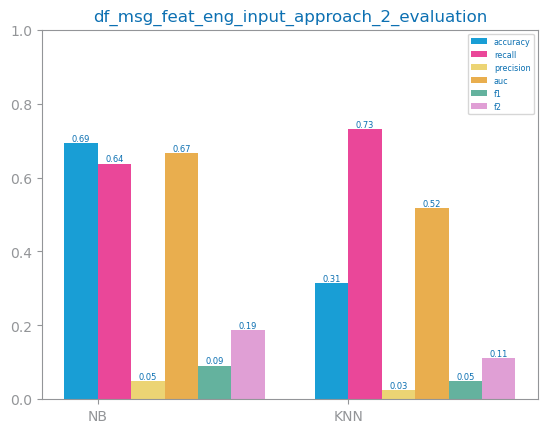

In [11]:
if evaluate == True:
    figure()
    eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='is_clicked', metric=target_metric)
    plot_multibar_chart(
        ["NB", "KNN"], eval_2, title=f"{file_tag}_approach_2_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_approach_2_evaluation.png")
    show()

# Bal 3 - SMOTE


## Bal 3 strategy aplication

In [12]:

def apply_strategy_3(df):

    # Create a copy of the dataframe
    df_copy = df.copy()

    df_smote=apply_balanced_smote(df_copy,target=target,sort_by='day_of_year')


    return df_smote


train_3=apply_strategy_3(train)
test_3=test.copy()

Original class distribution:
is_clicked
0.0    98.061366
1.0     1.938634
Name: proportion, dtype: float64

New class distribution:
is_clicked
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64



## Bal 3 distribution

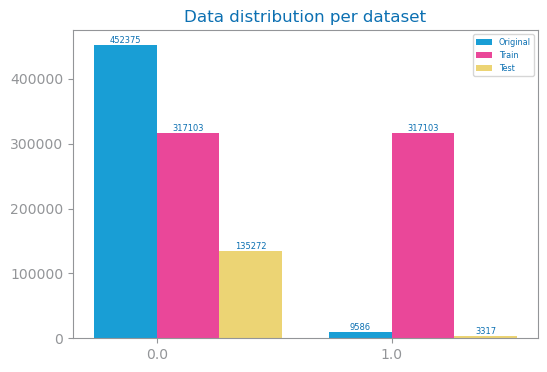

In [13]:
if evaluate==True:

    from pandas import concat
    from matplotlib.pyplot import figure, show
    from dslabs_functions import plot_multibar_chart


    # Distribution check


    # Create a dictionary to store original class counts
    values: dict[str, list[int]] = {
        "Original": [
            len(data[data[target] == 0]),  # Assuming 0 is the negative class
            len(data[data[target] == 1]),  # Assuming 1 is the positive class
        ]
    }

    values["Train"] = [
        len(train_3[train_3[target] == 0]),
        len(train_3[train_3[target] == 1]),
    ]
    values["Test"] = [
        len(test_3[test_3[target] == 0]),
        len(test_3[test_3[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Bal 3 evaluate

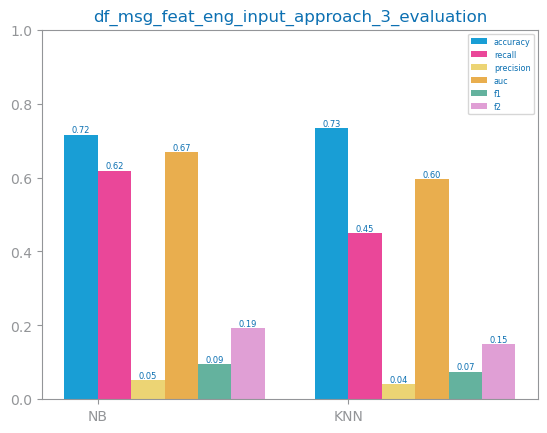

In [14]:
if evaluate == True:
    figure()
    eval_3: dict[str, list] = evaluate_approach(train_3, test_3, target='is_clicked', metric=target_metric)
    plot_multibar_chart(
        ["NB", "KNN"], eval_3, title=f"{file_tag}_approach_3_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_approach_3_evaluation.png")
    show()

# Balance 4 - Oversampling

## Bal 4 strategy Application

In [6]:
from pandas import DataFrame, Series
from sklearn.preprocessing import StandardScaler


def apply_strategy_1(df: DataFrame) -> DataFrame:

    df_copy=df.copy()

    df_balanced=apply_balanced_oversampling(df_copy,sort_by='day_of_year')
    
    return df_balanced


train_4=apply_strategy_1(train)
test_4=test.copy()



Original class distribution:
is_clicked
0.0    98.061366
1.0     1.938634
Name: proportion, dtype: float64

Balanced class distribution:
is_clicked
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64



## Bal 4 train/test split 

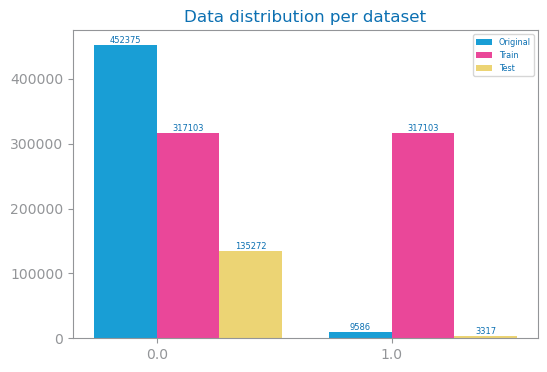

In [8]:
if evaluate==True:
    from pandas import concat
    from matplotlib.pyplot import figure, show
    from dslabs_functions import plot_multibar_chart


    # Distribution check


    # Create a dictionary to store original class counts
    values: dict[str, list[int]] = {
        "Original": [
            len(data[data[target] == 0]),  # Assuming 0 is the negative class
            len(data[data[target] == 1]),  # Assuming 1 is the positive class
        ]
    }

    values["Train"] = [
        len(train_4[train_4[target] == 0]),
        len(train_4[train_4[target] == 1]),
    ]
    values["Test"] = [
        len(test_4[test_4[target] == 0]),
        len(test_4[test_4[target] == 1]),
    ]

    # Visualize the distribution
    figure(figsize=(6, 4))
    plot_multibar_chart(labels, values, title="Data distribution per dataset")
    show()

## Bal 4 evaluate

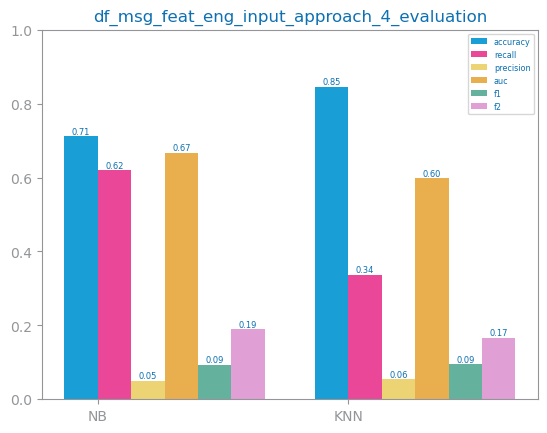

In [9]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values

if evaluate==True:
    figure()
    eval_1: dict[str, list] = evaluate_approach(train_4, test_4, target='is_clicked', metric=target_metric)
    plot_multibar_chart(
        ["NB", "KNN"], eval_1, title=f"{file_tag}_approach_4_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_approach_4_evaluation.png")
    show()

# Approach uplift comparison

## uplift df

In [19]:
algorithms = ['Naive Bayes', 'KNN']

# Create DataFrames for eval_1 and eval_2
df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
df_eval_2 = pd.DataFrame(eval_2, index=algorithms)

# Calculate uplift
df_uplift = df_eval_2 - df_eval_1

# Combine everything into one DataFrame (without misalignment issues)
comparison_df = pd.concat([df_eval_1, df_eval_2, df_eval_3], axis=1).T
comparison_df.columns = algorithms  # Set algorithms as columns
comparison_df.index = pd.MultiIndex.from_product([['Undersampling', 'Hybrid', 'SMOTE'], eval_1.keys()])

# Display the DataFrame
comparison_df

Naive Bayes       KNN
Undersampling accuracy      0.715389  0.634379
              recall        0.609888  0.656617
              precision     0.050357  0.042120
              auc           0.663932  0.645226
              f1            0.093033  0.079161
              f2            0.189274  0.167595
Hybrid        accuracy      0.693352  0.314989
              recall        0.637926  0.730178
              precision     0.048741  0.025108
              auc           0.666319  0.517493
              f1            0.090563  0.048547
              f2            0.186659  0.110362
SMOTE         accuracy      0.715555  0.733954
              recall        0.618330  0.449201
              precision     0.051012  0.040784
              auc           0.668134  0.595069
              f1            0.094249  0.074779
              f2            0.191775  0.149592

# Analysis

- some improvements in recall with hybrid approach, specifically in the KNN.

# unbalanced save to csv

In [13]:
if test_data==False:
    
    # do not balance original dataset      
    data_save=data.copy()
               
    data_save.to_csv(f"dataset/df_msg_bal_input.csv", index=False)

    # sampled versions to keep consistency    
    sample=0.075

    data_sample = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    data_sample.to_csv(f"dataset/df_msg_bal_input_sample.csv", index=False)

    
    print(data_save.columns)


Index(['platform', 'campaign_type', 'channel_cmp', 'total_count',
       'subject_with_emoji', 'day_of_year', 'is_weekend', 'month',
       'time_of_day', 'hour_sin', 'min_sin', 'min_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_week_nr_sin', 'day_of_week_nr_cos',
       'week_of_month_sin', 'week_of_month_cos', 'is_clicked'],
      dtype='object')


## train test and sample csv

In [15]:
if test_data==False:
   
    train_save=apply_strategy_3(train)         
    train_save.to_csv(f"dataset/df_msg_bal_input_train.csv", index=False)
 
    print(train.columns)

    test.to_csv(f"dataset/df_msg_bal_input_test.csv", index=False)
    print(test.columns)

    
    # sampled versions to keep consistency    
    sample=0.075
    
    train_save_sample = train_save.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    train_save_sample=apply_strategy_3(train_save_sample)         
    train_save_sample.to_csv(f"dataset/df_msg_bal_input_train_sample.csv", index=False)

        
    test_save_sample = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, sample)).reset_index(drop=True)
    test_save_sample.to_csv(f"dataset/df_msg_bal_input_test_sample.csv", index=False)
    
    
    print(test_save_sample.shape)

Original class distribution:
is_clicked
0.0    98.061366
1.0     1.938634
Name: proportion, dtype: float64

New class distribution:
is_clicked
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64

Index(['platform', 'campaign_type', 'channel_cmp', 'total_count',
       'subject_with_emoji', 'day_of_year', 'is_weekend', 'month',
       'time_of_day', 'hour_sin', 'min_sin', 'min_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_week_nr_sin', 'day_of_week_nr_cos',
       'week_of_month_sin', 'week_of_month_cos', 'is_clicked'],
      dtype='object')
Index(['platform', 'campaign_type', 'channel_cmp', 'total_count',
       'subject_with_emoji', 'day_of_year', 'is_weekend', 'month',
       'time_of_day', 'hour_sin', 'min_sin', 'min_cos', 'day_of_month_sin',
       'day_of_month_cos', 'day_of_week_nr_sin', 'day_of_week_nr_cos',
       'week_of_month_sin', 'week_of_month_cos', 'is_clicked'],
      dtype='object')
Original class distribution:
is_clicked
0.0    50.885032
1.0    49.